In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.base.datetools import dates_from_str

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Constructing an Arma Model

In [11]:
df = pd.read_csv("US_Full_Quarterly.csv",index_col="DATE")
df["Log GDP"] = np.log(df["GDP"])
df["Diff Log GDP"] = df["Log GDP"] - df["Log GDP"].shift(1)
df["Log Inv"] = np.log(df["Inv"])
df["Diff Log Inv"] = df["Log Inv"] - df["Log Inv"].shift(1)
df["Log Dependency"] = np.log(df["Dependency"])
for i in range(1,4):
    df["Log Dependency"]+= np.log(df["Dependency"].shift(i))
df["Log Dependency"] /= 4

df["Diff Log Dependency"] = df["Log Dependency"] - df["Log Dependency"].shift(4)

start_baseline = df["Log GDP"].loc["1959-12-01":].iloc[0]
baseline = df["Log GDP"].loc["2002-12-01":].iloc[0]
df.iloc[100:]


,GDP,Inv,Exp,Imp,Gov,Cons,NXP,Fertility,Unemployment,Life_exp,...,recession_1990,recession_2001,recession_2008,recession_2020,Log GDP,Diff Log GDP,Log Inv,Diff Log Inv,Log Dependency,Diff Log Dependency
DATE,,,,,,,,,,,,,,,,,,,,,
1972-01-01,1230.609,212.968,68.639,72.173,258.846,731.5,-3.534,2.010,5.8,71.156098,...,0,0,0,0,7.115264,0.033306,5.361142,0.070801,2.762855,0.000614
1972-04-01,1266.369,226.798,67.152,71.409,267.560,752.5,-4.257,2.010,5.7,71.156098,...,0,0,0,0,7.143909,0.028645,5.424060,0.062918,2.763210,0.000883
1972-07-01,1290.566,233.090,71.453,74.090,260.264,769.9,-2.637,2.010,5.6,71.156098,...,0,0,0,0,7.162836,0.018927,5.451425,0.027365,2.763566,0.001152
1972-10-01,1328.904,239.715,76.129,79.190,285.409,794.9,-3.061,2.010,5.6,71.156098,...,0,0,0,0,7.192110,0.029274,5.479451,0.028026,2.763921,0.001421
1973-01-01,1377.490,254.313,83.959,85.360,283.042,816.5,-1.401,1.879,4.9,71.356098,...,0,0,0,0,7.228018,0.035908,5.538566,0.059115,2.765163,0.002308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01,26408.405,4796.162,3013.800,3891.004,6175.709,17915.1,-877.204,NaN,3.6,NaN,...,1,1,1,1,10.181438,0.015792,8.475571,0.015029,3.272852,0.029126
2023-01-01,26813.601,4725.828,3064.804,3890.491,6324.782,18229.6,-825.687,NaN,3.4,NaN,...,1,1,1,1,10.196665,0.015227,8.460798,-0.014773,NaN,NaN
2023-04-01,27063.012,4780.290,2961.759,3767.851,6346.294,18363.8,-806.092,NaN,3.4,NaN,...,1,1,1,1,10.205923,0.009259,8.472256,0.011458,NaN,NaN


<AxesSubplot: xlabel='DATE'>

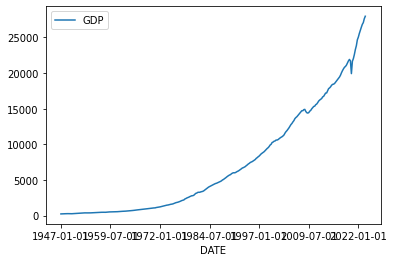

In [12]:
df.plot(y = ["GDP"])

In [4]:
# Combine variables into a single DataFrame
# I opted to start at 1990 because that's when the data starts to become yearly. 
# We should really fix the dataset to get yearly data for the first 30 years though
variables = ['Diff Log GDP',"Diff Log Inv","Diff Log Dependency"]
df_var = df[variables].loc['1960-01-01':'2017-02-01']
df_var.index = pd.period_range(start='1960-01-01', end='2017-02-01', freq='Q-DEC')

# Fit VARMAX model
model = VARMAX(df_var, order=(4, 4)) # TODO: I chose the order (p=2,q=2) arbitrarily. We should probably do some AIC or something to find the best choice
results = model.fit(disp=False)

/home/acherpeski/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/acherpeski/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


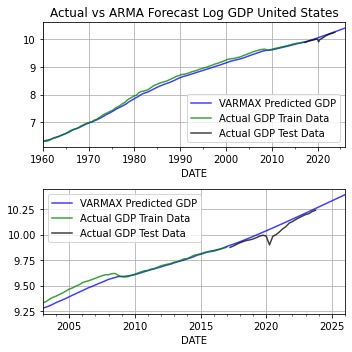

{'trend': 3, 'ar': 36, 'ma': 36, 'regression': 0, 'state_cov': 6, 'obs_cov': 0}


In [5]:
# Forecast GDP
forecast_steps = 5  # Number of steps ahead to forecast
forecast = results.forecast(steps=forecast_steps)

# These two lines let us plot confidence intervals I think.loc['2003-01-01':]
#forecast_obj = results.get_forecast('2020')
#allConfidenceIntervals = forecast_obj.conf_int(alpha=0.05)
#.loc['2003-12-01'])
# Plot GDP along with the smoothed version (and forecasted through 2030)
fig, axes = plt.subplots(figsize=(5,5),nrows=2, ncols=1)
pred = results.predict('1960', '2026') # If we wanted to show only the future prediction, we would change the start date to 2017

# Make the indices match up properly
pred.index = pd.to_datetime(pred.index.strftime('%Y-%m'))
df_var.index = pd.to_datetime(df_var.index.strftime('%Y-%m'))
df.index = pd.to_datetime(df.index)

pred["Log GDP"] = np.cumsum(pred['Diff Log GDP'])+start_baseline
pred["Log GDP"].plot(ax = axes[0],alpha = .75, label="VARMAX Predicted GDP", color='b', markersize=4)
(np.cumsum(df_var['Diff Log GDP']) + start_baseline).plot(ax=axes[0],alpha = .75, label="Actual GDP Train Data", color='g', markersize=4)
df.loc['2017-02-01':].plot(ax = axes[0],alpha = .75, y="Log GDP",label = "Actual GDP Test Data", color='k', markersize=4)
axes[0].set_title('Actual vs ARMA Forecast Log GDP United States')
axes[0].legend()
axes[0].grid(True)

# Plotting forecasted and actual GDP from 2003 onwards
pred['Log GDP'].loc['2003-01-01':].plot(ax=axes[1],alpha = .75, label="VARMAX Predicted GDP", color='b', markersize=4)
(np.cumsum(df_var['Diff Log GDP'].loc['2003-01-01':]) + baseline).plot(ax=axes[1],alpha = .75, label="Actual GDP Train Data", color='g', markersize=4)

df.loc['2017-02-01':].plot(ax = axes[1],alpha = .75, y="Log GDP",label = "Actual GDP Test Data", color='k', markersize=4)  # Plotting actual GDP from 2017 onwards
axes[1].legend()
axes[1].grid(True)

# Adjusting layout and saving the figure
fig.tight_layout()
fig.savefig("Actual vs Forecast Log GDP United States 1960-2026.jpg", dpi=300)
plt.show()
len(model.param_names)
print(model.parameters)



Because the ARMA model is an additive model, we work with log values just as we did previously. Although many factors possibly influence GDP, we will focus here on a vector of values that involves the logarithm of GDP, the logarithm of Investment, and the logarithm of the dependency ratio that serves as a proxy for population structure. Our model takes the following form:
$$\Delta Z_t = \textbf{c} + \Bigg (  \sum_{i=1}^p \Phi_i y_{t-i}  \Bigg)+ \Bigg (  \sum_{j=0}^q \Theta_j \epsilon_{t-j}  \Bigg)$$

Where each $y_t = Z_t - Z_{t-1}$
